In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `~/GitHub/MathSys/teaching/MA999/MA999-slides/Project.toml`


In [2]:
using Plots
using LaTeXStrings
using DifferentialEquations
using Agents
using DataFrames
using Statistics

In [3]:
include("code/DW.jl")

Main.DW

# MA999 - Agent based modelling - notes 2

## MathSys CDT 2021

### Lecturer: Colm Connaughton

## The Gaia Hypothesis

The interactions between the biological and non-biological components of the Earth system form a self-regulating complex system which acts to maintain the conditions favourable to life on the planet.

Watson & Lovelock (1983)

Criticised by evolutionary biologists since it seemed to imply large scale cooperation between organisms counter to prevailing theories of natural selection

## Daisyworld model

The Daisyworld model is a minimal model of a planetary ecology demonstrating that thermoregulation can emerge from *competitive* interaction between species.

### Model ingredients:

* Daisyworld is home to two species of daisies, black daisies and white daisies, that are identical in all respects other than their color.
* Daisies compete for space on Daisywork by spreading to occupy available bare ground.
* Daisies' rate of reproduction, $\beta(T)$, is a function of temperature with a single maximum at $T_\text{opt}$.
* Daisies' rate of death is constant, $\gamma$.
* Daisies interact with the environment through their *albedo*:
    * Black daisies absorb sunlight and increase the local temperature above that of bare ground.
    * White daisies reflect sunlight and decrease the local temperature below that of bare ground.

## Mathematical model of Daisyworld

The orginal model of Watson and Lovelock was a mean-field model that did not explicitly account for space. The dependent variables are the *proportions* of the surface area occupied by the white and black daisies:
* $A_w(t)$ : proportion of the surface occupied by white daisies.
* $A_b(t)$ : proportion of the surface occupied by black daisies.

We denote by $A_0(t)$ the proportion of the surface that is bare. Clearly we have the constraint:
$$ A_w(t) + A_b(t) + A_0(t) = 1$$

### Modelling the growth rate of daisies

We need a model of the growth rate of the daisies. A parabolic function is the simplest:

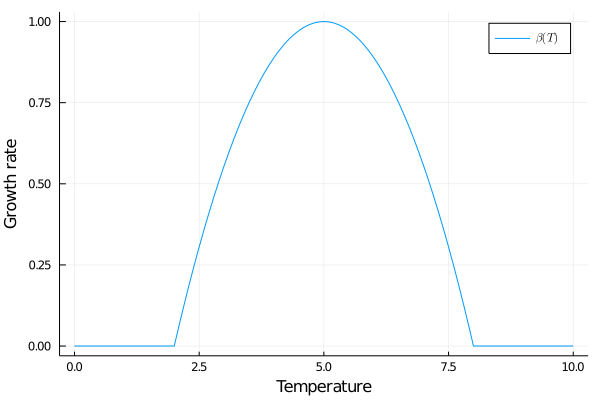

In [5]:

X = 0:0.1:10
xm = 5
xr = 3
f(x) = max(-(x-xm+xr)*(x-xm-xr)/xr^2, 0.0)
Y = f.(X)
plot(X,Y, label=L"\beta (T)", ylabel = "Growth rate", xlabel="Temperature" )

### Modelling the population dynamics of the daisies

We can use standard mean-field population dynamics equations to model the competitive dynamics of the daisies.

$$ \frac{d A_w}{d t} = \beta(T_w)\, A_w\, A_0 - \gamma\,A_w $$
$$ \frac{d A_b}{d t} = \beta(T_b)\, A_b\, A_0 - \gamma\,A_b $$

with $A_0(t) = 1 - A_w(t) - A_b(t)$.

In these equations, $T_w$ and $T_b$ are the local temperatures of patches of white and black daisies respectively.

### Modelling the average global temperature of Daisyworld

The key to modelling the temperature is to capture incorporate concept of albedo. The albedo of a surface is the proportion of incoming radiation that it reflects. 
* An albedo of 1 means all incoming radiation is reflected (resulting in a cooler surface). 
* An albedo of 0 means all incoming radiation is absorbed (resulting in a hotter surface).

If $F$ is the incoming solar radiation flux, the average temperature of Daisyworld, $T_\text{av}$, is given by the [Stefan-Boltzmann law](https://www.britannica.com/science/Stefan-Boltzmann-law):
$$ \sigma T_\text{av}^4 = F\,(1-\alpha)$$
where $\alpha$ is the average albedo of the surface and $\sigma$ is a constant of proportionality.

If $\alpha_w$, $\alpha_b$ and $\alpha_0$ are the albedos of white, black and bare patches respectively (conventionally taken to be 3/4, 1/4 and 1/2), then the average albedo is
$$ \alpha(t) = \alpha_w\, A_w(t) + \alpha_b\,A_b(t) + \alpha_0\,A_0(t)$$.

### Modelling the local temperatures

However, daisies don't experience the global temperature, they experience local modified temperatures that depend on the difference between the local and average albedo:

$$ T_w^4 = T_\text{av}^4 + q\,(\alpha - \alpha_w) $$
$$ T_b^4 = T_\text{av}^4 + q\,(\alpha - \alpha_b) $$
$$ T_0^4 = T_\text{av}^4 + q\,(\alpha - \alpha_0). $$

Here $q$ is a phenomenological modelling parameter (akin to a diffusion coefficient) controlling the strength of local variations in temperature. 

Later, we will do away with the need to make this assumption in an agent-based variation of the Daisyworld model which incorporates spatial structure directly.

Note that since we have already written $T_\text{av}$ and $\alpha$ in terms of $A_w$ and $A_b$, we now have a closed set of differential equations which we can solve.

## Solving differential equations in Julia: DifferentialEquations.jl

Julia has a well developed system for solving systems of differential equations called [DifferentialEquations.jl](https://docs.juliadiffeq.org/stable/). In its basic form, it is very simple to use. Here is an example that solves the Lorentz equations:

### Step 1: define the RHS of the system of equations

* ```du``` is the right hand side of the system (as a vector)
* ```u``` are the dependent variables for (as a vector)
* ```t``` is the time variable (for non-autonomous systems)
* ```p``` is a list of parameters that need to be passed in

In [6]:
# First we define the RHS:
function lorenz!(du,u,p,t)
    x,y,z = u
    σ,ρ,β = p
    du[1] = dx = σ*(y-x)
    du[2] = dy = x*(ρ-z) - y
    du[3] = dz = x*y - β*z
end

lorenz! (generic function with 1 method)

### Step 2: define the problem

This entails
* specifying the initial condition, ```u0```.
* specifying the time interval in which to solve the equations, ```tspan```
* providing values for the parameters, ```p```
* creating an ```ODEProblem``` object which takes ```u0```, ```tspan```, ```p``` and the RHS function from step 1 as arguments.

In [7]:
u0 = [1.0,0.0,0.0]
tspan = (0.0,100.0)
p = [10.0,28.0,8/3]
prob = ODEProblem(lorenz!,u0,tspan,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [1.0, 0.0, 0.0]

### Step 3: integrate the equation

In [8]:
sol = solve(prob)

retcode: Success
Interpolation: automatic order switching interpolation
t: 1294-element Array{Float64,1}:
   0.0
   3.5678604836301404e-5
   0.0003924646531993154
   0.0032624077544510573
   0.009058075635317072
   0.01695646895607931
   0.0276899566248403
   0.041856345938267966
   0.06024040228733675
   0.08368539694547242
   0.11336497050342806
   0.14862178548871152
   0.18703974465019643
   ⋮
  99.15166031662457
  99.22514723290307
  99.31227549560941
  99.39403070915297
  99.47001147494375
  99.54379656909015
  99.614651558349
  99.69093823148101
  99.78733023233721
  99.86114450046736
  99.96115759510786
 100.0
u: 1294-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]
 [0.9996434557625105, 0.0009988049817849058, 1.781434788799208e-8]
 [0.9961045497425811, 0.010965399721242457, 2.146955365838907e-6]
 [0.9693591634199452, 0.08977060667778931, 0.0001438018342266937]
 [0.9242043615038835, 0.24228912482984957, 0.0010461623302512404]
 [0.8800455868998046, 0.43873645009348244, 0.0034

### Step 4: plot and analyse the solution.

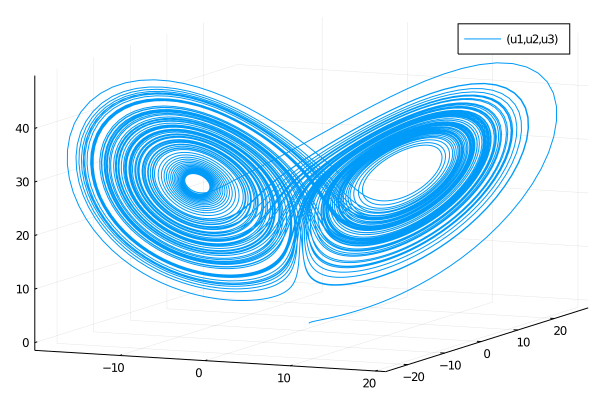

In [9]:
plot(sol,vars=(1,2,3))

## Solving the Daisyworld equations

First we set up the parameters

In [10]:
# Define parameters
Topt = 5
ΔT = 6
γ = 0.1
αw = 0.75
αb = 0.25
α0 = 0.5
σ = (1.0 - α0)/(Topt^4.0)
q = 0.25

β(T) = max(-(T-Topt+ΔT/2.0)*(T-Topt-ΔT/2)/(ΔT/2.0)^2, 0.0)
F(t) = 1.0


F (generic function with 1 method)

In [11]:
p = [β, γ, αw, αb, α0, σ, q, F ]
u0 = [0.08,0.12]
tspan = (0.0,100.0)

(0.0, 100.0)

Here's a function that defines the right-hand side of the equations:

In [12]:
function daisyworld!(du,u,p,t)
    # Get the dependent variables
    Aw,Ab = u
    # Get the parameters
    β, γ, αw, αb, α0, σ, q, F  = p 
    # Proportion of bare ground:
    A0 = 1.0 - Aw - Ab
    # Work out average albedo and temperature
    α = αw*Aw + αb*Ab + α0*A0
    Tav = (F(t)*(1.0-α)/σ)^0.25
    # Work out local temperatures:
    Tw = (Tav^4.0 + q*(α - αw))^0.25
    Tb = (Tav^4.0 + q*(α - αb))^0.25
    # Construct the RHS of the population dynamics equations
    du[1] = β(Tw)*Aw*A0 - γ*Aw
    du[2] = β(Tb)*Ab*A0 - γ*Ab
end

daisyworld! (generic function with 1 method)

Now we can integrate the equations as we did for the Lorentz model:

In [13]:
prob = ODEProblem(daisyworld!,u0,tspan,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.08, 0.12]

In [14]:
sol = solve(prob);

Here's how to extract the individual components of the solution for analysis

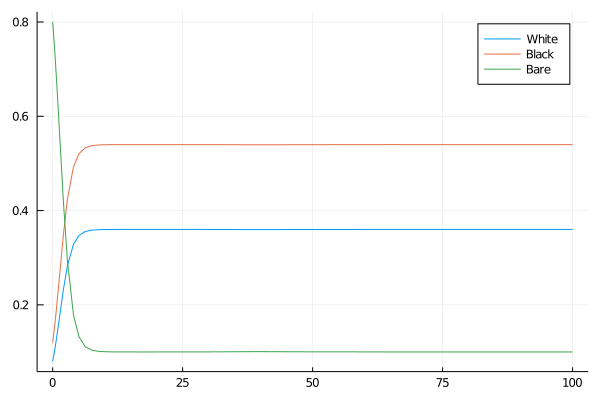

In [15]:
t = sol.t
Aw = sol[1,:]
Ab = sol[2,:]
A0 = 1.0 .- Aw .-Ab
plot(t, Aw, label="White")
plot!(t,Ab, label="Black")
plot!(t,A0, label="Bare")

Here's the average temperature

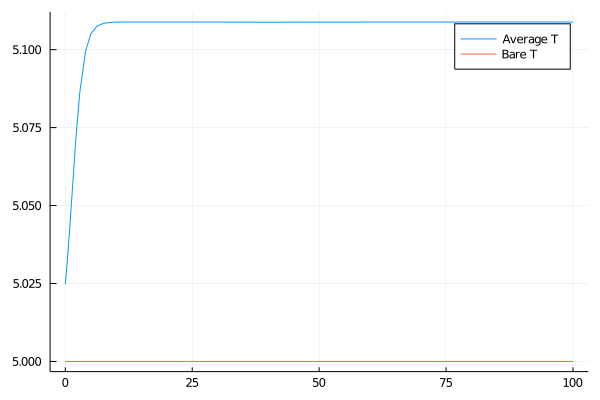

In [16]:
α = αw .* Aw .+   αb .* Ab .+ α0 .* A0
Tav = (F.(t).*(1.0 .- α)./σ).^0.25
Tbare = (F.(t).*(1.0 .- α0)./σ).^0.25
plot(t, Tav, label="Average T")
plot!(t, Tbare, label = "Bare T")

## Agent based version of the Daisyworld model

The way in which local temperature variation is handled in the mean field Daisyworld model is not entirely transparent. 

An ABM version of Daisyworld will be modeled as a 2-D grid.

Agents correspond to patches associated with grid points. Each patch has its own colour (with corresponding albedo) and local temperature.

In an ABM each patch can absorb a fixed fraction of solar irradiance at each time step to assign it a temperature. Local temperatures can then be calculated in a natural way by averaging over the temperatures of neighbouring cells.

### Descriptive specification of the model dynamics

At each step:
1. each white/black patch picks a random neighbouring patch. If that patch is bare, a new white/black patch is created there with probability $p_\beta(T_\text{local})$. 
2. each white/black patch dies with probability $p_\gamma$.
3. each patch updates its local temperature to be $\alpha F$ where $F$ is the solar irradiance and $\alpha$ is the appropriate albedo value.
4. after all agents have updated the local temperatures of all agents are recalculated by performing a weighted average of the local temperatures.

It is natural to encode steps 1 - 3 in the ```agent_step!()``` function and step 4 in the ```model_step!()``` function. 

### Agent definition

Let's get started.

Here's the basic definition of an agent:

In [17]:
@agent daisy_patch GridAgent{2} begin
    colour::Int
    temperature::Float64
end

### Model properties

As with our transportation example, we encode the parameters in a ```Dict()``` to pass to the model object:

In [6]:
size = 25
T_opt = 22.5
T_range = 10.0
P_death = 0.1
P_growth = 0.05
delta = 0.25
albedo = [0.75, 0.25, 0.5]
F(step) = (T_opt + T_range)*2.0
β(T) = max(-(T-T_opt+T_range)*(T-T_opt-T_range)/T_range^2, 0.0)

properties = Dict{Symbol,Any}(:T_opt => T_opt, 
    :T_range=>T_range, 
    :P_death=>P_death, 
    :P_growth=>P_growth, 
    :delta=>delta,
    :step=>0,
    :flux=>F,
    :growth_rate=>β,
    :albedo=>albedo
)

Dict{Symbol,Any} with 9 entries:
  :flux        => F
  :growth_rate => β
  :P_death     => 0.1
  :step        => 0
  :T_opt       => 22.5
  :P_growth    => 0.05
  :T_range     => 10.0
  :delta       => 0.25
  :albedo      => [0.75, 0.25, 0.5]

In [ ]:
tmp = Dict{Symbol,Any}(:T_opt => T_opt, 
    :T_range=>T_range, 
    :P_death=>P_death, 
    :P_growth=>P_growth, 
    :delta=>delta,
    :flux=>F,
    :step=>0,
    :growth_rate=>β,
    :albedo=>albedo)

### Agent step function

Here is the agent step function:

In [19]:
function agent_step!(agent, model)
    if agent.colour == 3
        # With low probability an empty patch can grow daisies
        rand() <= model.P_growth && (agent.colour = rand([1,2]))
    else
        # An occupied patch can attempt to reproduce
        T = agent.temperature
        neighbour = rand(collect(nearby_agents(agent, model)))
        if neighbour.colour == 3
            rand() <= model.growth_rate(T) && (neighbour.colour = agent.colour)
        end
        # An occupied patch can die and revert to being empty.
        rand() <= model.P_death && (agent.colour = 3)
    end
end

agent_step! (generic function with 1 method)

Note that we allow "spontaneous regrowth" with low probability to avoid the absorbing state (no daisies).

### Model step function

The model step function needs to calculate the local temperatures



In [20]:
function model_step!(model)
    t =  model.step; δ = model.delta; F = model.flux; 
    # Calculate the proportion of absorbed energy
    A = [1.0- x for x in model.albedo]
    # Calculate the temperature at each point in the space
    for pos in positions(model)
        agent = collect(agents_in_position(pos, model))[1]
        T1 = A[agent.colour]*F(t)
        neighbours = collect(nearby_agents(agent, model))
        T2=0.0
        for n in neighbours
            T2 += A[n.colour]*F(t)
        end
        T2 = T2/(length(neighbours))
        # Update the local temperature to be a weighted sum of T1 and T2
        agent.temperature = (1.0-δ)*T1 + δ*T2
    end
    model.step = t+1
end

model_step! (generic function with 1 method)

### Model initialisation

As with the previous example, it is convenient to combine the model initialisation steps into a function:

In [21]:
function initialise(;dims = (size,size), properties=properties)
    # Create the underlying space
    space = GridSpace(dims, periodic = true) 
    model = ABM(daisy_patch, space; scheduler = fastest, properties=properties)
    # Initial temperature is that of "bare" planet
    Tinit = properties[:flux](1)*properties[:albedo][3]
    # Add an agent to each node of the space. Initially all have type 3 (empty) and temperature T_init
    for node in nodes(model)
        add_agent!(node, model, 3, T_init)
    end
    return model
end

model = initialise(dims=(size,size),properties=properties)

AgentBasedModel with 625 agents of type daisy_patch
 space: GridSpace with size (25, 25), metric=chebyshev and periodic=true
 scheduler: fastest
 properties: Dict{Symbol,Any}(:flux => F,:growth_rate => β,:P_death => 0.1,:step => 0,:T_opt => 22.5,:P_growth => 0.05,:T_range => 10.0,:delta => 0.25,:albedo => [0.75, 0.25, 0.5])

### Running the model and gathering data

Let's just gather all agent states at each step rather than trying to do fancy data aggregation on the fly.

In [24]:
nsteps=50
adata = [:pos, :colour, :temperature]
when = 1:nsteps  # At which steps to collect data
data, _  = run!(model, agent_step!, model_step!, nsteps; adata);
data[1:10, :] # print only a few rows

,step,id,pos,colour,temperature
,Int64,Int64,Tuple…,Int64,Float64
1,0,1,"(1, 1)",3,0.0
2,0,2,"(2, 1)",3,0.0
3,0,3,"(3, 1)",3,0.0
4,0,4,"(4, 1)",3,0.0
5,0,5,"(5, 1)",3,0.0
6,0,6,"(6, 1)",3,0.0
7,0,7,"(7, 1)",3,0.0
8,0,8,"(8, 1)",3,0.0
9,0,9,"(9, 1)",3,0.0


### Analysing the results

To visualise the simulation results, I think we need more power/flexibility than is provided by PlotAgents.jl. Instead we can use Plots.jl to build plots directly from the ```data``` DataFrame generated by the model.

The @animate macro is very useful to create movies showing how the model evolves in time:

In [26]:
anim = @animate for i in when
    plt=plot(5,xlim=(0,size),ylim=(0,size), c=:red, aspect_ratio=1,legend=false, framestyle=:origin)
    frame = data[data.step .== i, :]
    group1 = frame[frame.colour .== 1, :]
    group2 = frame[frame.colour .== 2, :]
    group3 = frame[frame.colour .== 3, :]
    scatter!(group1.pos, markersize=10, color="black", label="")
    scatter!(group2.pos, markersize=10, color="white", label="")
    scatter!(group3.pos, markersize=10, color="brown", label="")
end

Animation("/var/folders/9s/_cwljx6912983yg6z8qcx7p40000gn/T/jl_XEt3qJ", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

### Running the movie

The results are created as an animated gif file. Read the output below to see where the file is located. It can be viewed in a Jupyter notebook as follows:

┌ Info: Saved animation to 
│   fn = /Users/colmconnaughton/Dropbox/teaching/MA999-MathematicalModelling/notes/tmp.gif
└ @ Plots /Users/colmconnaughton/.julia/packages/Plots/KN96c/src/animation.jl:104


Plots.AnimatedGif("/Users/colmconnaughton/Dropbox/teaching/MA999-MathematicalModelling/notes/tmp.gif")
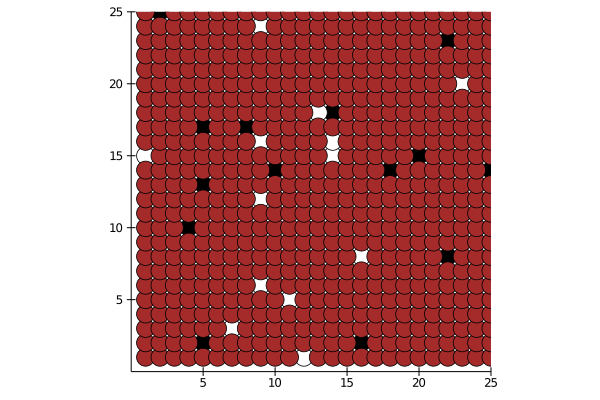

In [27]:
gif(anim, fps = 1)

### Calculate the populations of white and black daisies and the temperature

This requires a bit of post=processing on ```data```

In [28]:
# Extract some aggregated quantities from the simulation
# Mean temperature of daisyworld as a function of step
 gdf = groupby(data, :step)
df_T = combine(gdf, :temperature => mean => :T_average)
    
gdf = groupby(data, [:step, :colour]);
df = combine(gdf, nrow => :count);
colour_df = groupby(df, :colour);
g1 = get(colour_df, (colour=1,), nothing);
g2 = get(colour_df, (colour=2,), nothing);
g3 = get(colour_df, (colour=3,), nothing);

### Create the plot

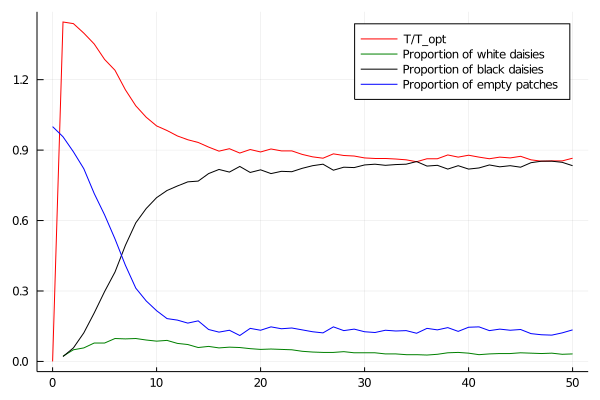

In [29]:
p = plot(df_T.step, df_T.T_average /T_opt, label = "T/T_opt", color="red")
plot!(g1.step, g1.count/size^2, label = "Proportion of white daisies", color="green")
plot!(g2.step, g2.count/size^2, label = "Proportion of black daisies", color="black")
plot!(g3.step, g3.count/size^2, label = "Proportion of empty patches", color="blue")

## The end

Hopefully you now know the basics of how to build, visualise and analyse ABMs in Julia. Do let me know if you ever use any of this for your own research!

## Useful links
* DifferentialEquation.jl documentation : https://docs.juliadiffeq.org/stable/

## References

[Watson, Andrew J., and James E. Lovelock. "Biological homeostasis of the global environment: the parable of Daisyworld." Tellus B: Chemical and Physical Meteorology 35, no. 4 (1983): 284-289.](https://www.tandfonline.com/doi/pdf/10.3402/tellusb.v35i4.14616)

In [7]:
# Change the solar flux to see what happens
F2(step) = (T_opt + T_range)*1.5
data, p = DW.run(50, F=F2)

(31875×5 DataFrame
   Row │ step   id     pos       colour  temperature 
       │ Int64  Int64  Tuple…    Int64   Float64     
───────┼─────────────────────────────────────────────
     1 │     0      1  (1, 1)         3      24.375
     2 │     0      2  (2, 1)         3      24.375
     3 │     0      3  (3, 1)         3      24.375
     4 │     0      4  (4, 1)         3      24.375
     5 │     0      5  (5, 1)         3      24.375
     6 │     0      6  (6, 1)         3      24.375
     7 │     0      7  (7, 1)         3      24.375
     8 │     0      8  (8, 1)         3      24.375
     9 │     0      9  (9, 1)         3      24.375
    10 │     0     10  (10, 1)        3      24.375
    11 │     0     11  (11, 1)        3      24.375
   ⋮   │   ⋮      ⋮       ⋮        ⋮          ⋮
 31866 │    50    616  (16, 25)       3      22.0898
 31867 │    50    617  (17, 25)       3      21.709
 31868 │    50    618  (18, 25)       2      13.3301
 31869 │    50    619  (19, 25)       3  

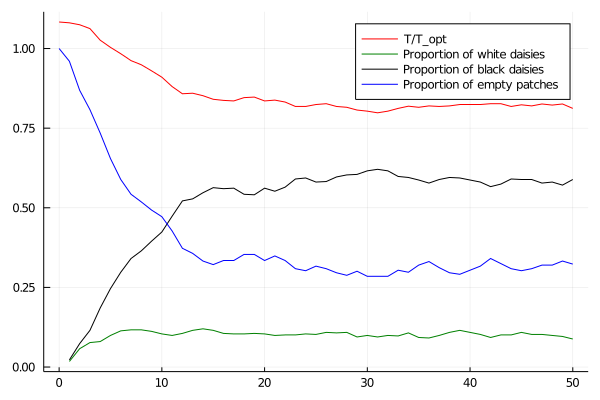

In [8]:
p